In [1]:
!pip install -q datasets transformers torch torchvision accelerate pandas tqdm

In [2]:
from datasets import load_dataset
import pandas as pd
import os
from tqdm.notebook import tqdm

# Reduced subset sizes for stability
TRAIN_SIZE = 5000
VAL_SIZE = 1000
IMAGE_DIR = "gqa_images"
os.makedirs(IMAGE_DIR, exist_ok=True)

print("📁 Directory ready:", IMAGE_DIR)


📁 Directory ready: gqa_images


In [3]:
train_dataset = load_dataset("lmms-lab/GQA", "train_balanced_instructions", split=f"train[:{TRAIN_SIZE}]")
val_dataset = load_dataset("lmms-lab/GQA", "val_balanced_instructions", split=f"val[:{VAL_SIZE}]")

df_train = pd.DataFrame(train_dataset)
df_val = pd.DataFrame(val_dataset)

print(f"✅ Loaded {len(df_train)} training and {len(df_val)} validation samples")
df_train.head()


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

train_balanced_instructions/train-00000-(…):   0%|          | 0.00/184M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/943000 [00:00<?, ? examples/s]

val_balanced_instructions/val-00000-of-0(…):   0%|          | 0.00/25.8M [00:00<?, ?B/s]

Generating val split:   0%|          | 0/132062 [00:00<?, ? examples/s]

✅ Loaded 5000 training and 1000 validation samples


,id,imageId,question,answer,fullAnswer,isBalanced,groups,entailed,equivalent,types,annotations,semantic,semanticStr
0,02930152,2354786,Is the sky dark?,yes,"Yes, the sky is dark.",True,"{'global': None, 'local': '06-sky_dark'}","['02930160', '02930158', '02930159', '02930154...",['02930152'],"{'structural': 'verify', 'semantic': 'attr', '...","{'question': [{'objectId': '2', 'value': '2486...","[{'operation': 'select', 'argument': 'sky (248...",select: sky (2486325)->verify color: dark [0]
1,07333408,2375429,What is on the white wall?,pipe,The pipe is on the wall.,True,"{'global': '', 'local': '14-wall_on,s'}",[],['07333408'],"{'structural': 'query', 'semantic': 'rel', 'de...","{'question': [{'objectId': '4:6', 'value': '72...","[{'operation': 'select', 'argument': 'wall (72...",select: wall (722332)->filter color: white [0]...
2,07333405,2375429,Is that pipe red?,no,"No, the pipe is white.",True,"{'global': None, 'local': '06-pipe_red'}",['07333406'],['07333405'],"{'structural': 'verify', 'semantic': 'attr', '...","{'question': [{'objectId': '2', 'value': '7223...","[{'operation': 'select', 'argument': 'pipe (72...",select: pipe (722335)->verify color: red [0]
3,15736264,2368326,Is the tall clock small or large?,large,The clock is large.,True,"{'global': 'size', 'local': '10c-clock_size'}","['15736259', '15736258', '15736267', '15736253...",['15736264'],"{'structural': 'choose', 'semantic': 'attr', '...","{'question': [{'objectId': '2:4', 'value': '74...","[{'operation': 'select', 'argument': 'clock (7...",select: clock (746851)->filter height: tall [0...
4,111007521,2331819,Who is wearing a shirt?,girl,The girl is wearing a shirt.,True,"{'global': 'person', 'local': '14-shirt_wearin...",[],['111007521'],"{'structural': 'query', 'semantic': 'rel', 'de...","{'question': [{'objectId': '4', 'value': '4653...","[{'operation': 'select', 'argument': 'shirt (4...","select: shirt (4653737)->relate: person,wearin..."


In [4]:
import requests
from PIL import Image

IMAGE_BASE_URLS = [
    "https://cs.stanford.edu/people/rak248/VG_100K/",
    "https://cs.stanford.edu/people/rak248/VG_100K_2/"
]

unique_ids = list(set(df_train["imageId"].tolist() + df_val["imageId"].tolist()))
print(f"Downloading {len(unique_ids)} images...")

for image_id in tqdm(unique_ids):
    filename = f"{image_id}.jpg"
    path = os.path.join(IMAGE_DIR, filename)
    if os.path.exists(path):
        continue
    success = False
    for base in IMAGE_BASE_URLS:
        try:
            r = requests.get(base + filename, stream=True, timeout=5)
            if r.status_code == 200:
                with open(path, "wb") as f:
                    for chunk in r.iter_content(1024):
                        f.write(chunk)
                success = True
                break
        except:
            continue
    if not success:
        print(f"⚠️ Skipped {filename}")

print("✅ Image download complete.")


  0%|          | 0/4600 [00:00<?, ?it/s]

✅ Image download complete.


In [5]:
from transformers import DistilBertTokenizerFast, ViTImageProcessor

tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")
image_processor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224")

print("✅ Tokenizer and Image Processor loaded")


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

✅ Tokenizer and Image Processor loaded


In [6]:
import torch
from PIL import Image

def preprocess_batch(example):
    question = example["question"]
    image_id = example["imageId"]
    label = example["answer"]

    # Skip if missing data
    if not isinstance(question, str) or not isinstance(label, str):
        return None

    # Text
    text_inputs = tokenizer(
        question, padding="max_length", truncation=True, max_length=128, return_tensors="pt"
    )

    # Image
    path = os.path.join(IMAGE_DIR, f"{image_id}.jpg")
    try:
        image = Image.open(path).convert("RGB")
    except:
        return None

    image_inputs = image_processor(image, return_tensors="pt")

    return {
        "input_ids": text_inputs["input_ids"].squeeze(0),
        "attention_mask": text_inputs["attention_mask"].squeeze(0),
        "pixel_values": image_inputs["pixel_values"].squeeze(0),
        "label": label,
    }


In [7]:
from torch.utils.data import Dataset, DataLoader

class GQADataset(Dataset):
    def __init__(self, dataframe, transform_fn):
        self.data = dataframe.reset_index(drop=True)
        self.transform_fn = transform_fn

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.transform_fn(self.data.iloc[idx])

answers = sorted(df_train["answer"].unique().tolist())
answer2label = {a: i for i, a in enumerate(answers)}
label2answer = {i: a for a, i in answer2label.items()}

def collate_fn(batch):
    batch = [b for b in batch if b is not None and b["label"] in answer2label]
    if len(batch) == 0:
        return None
    return {
        "input_ids": torch.stack([b["input_ids"] for b in batch]),
        "attention_mask": torch.stack([b["attention_mask"] for b in batch]),
        "pixel_values": torch.stack([b["pixel_values"] for b in batch]),
        "labels": torch.tensor([answer2label[b["label"]] for b in batch]),
    }

train_data = GQADataset(df_train, preprocess_batch)
val_data = GQADataset(df_val, preprocess_batch)

train_loader = DataLoader(train_data, batch_size=8, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_data, batch_size=8, shuffle=False, collate_fn=collate_fn)

print(f"✅ Train batches: {len(train_loader)}, Validation batches: {len(val_loader)}")


✅ Train batches: 625, Validation batches: 125


In [8]:
# ✅ Cell 8 — Define Early Fusion Model (Text + Image)
import torch
import torch.nn as nn
from transformers import AutoModel, AutoImageProcessor, AutoModelForImageClassification

class EarlyFusionModel(nn.Module):
    def __init__(self, text_model_name="bert-base-uncased", img_model_name="google/vit-base-patch16-224", num_classes=100):
        super(EarlyFusionModel, self).__init__()

        # Text encoder
        self.text_encoder = AutoModel.from_pretrained(text_model_name)
        self.text_proj = nn.Linear(self.text_encoder.config.hidden_size, 256)

        # Image encoder
        self.img_encoder = AutoModel.from_pretrained(img_model_name)
        self.img_proj = nn.Linear(self.img_encoder.config.hidden_size, 256)

        # Fusion + Classifier
        self.fusion = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, num_classes)
        )

    def forward(self, input_ids, attention_mask, pixel_values):
        # Text features (CLS token)
        text_feats = self.text_encoder(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state[:, 0, :]
        text_feats = self.text_proj(text_feats)

        # Image features (CLS token)
        img_feats = self.img_encoder(pixel_values=pixel_values).last_hidden_state[:, 0, :]
        img_feats = self.img_proj(img_feats)

        # Early fusion
        combined = torch.cat((text_feats, img_feats), dim=1)
        outputs = self.fusion(combined)
        return outputs


# Initialize model
num_classes = len(answer2label)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = EarlyFusionModel(num_classes=num_classes).to(device)
print(f"✅ Early Fusion model initialized on {device} with {num_classes} output classes")


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Early Fusion model initialized on cuda with 584 output classes


In [9]:
import torch
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, f1_score
from tqdm.auto import tqdm
import numpy as np

# -------------------------------
# Training Configuration
# -------------------------------
EPOCHS = 5
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.8)
criterion = nn.CrossEntropyLoss()

best_val_loss = float("inf")
patience = 2  # early stopping
patience_counter = 0

# -------------------------------
# Training + Validation Loop
# -------------------------------
for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}", leave=False)

    for batch in loop:
        if batch is None:  # skip empty batches
            continue

        optimizer.zero_grad()

        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        pixel_values = batch["pixel_values"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(input_ids, attention_mask, pixel_values)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        loop.set_postfix(loss=loss.item())

    scheduler.step()
    avg_train_loss = total_loss / len(train_loader)

    # -------------------------------
    # Validation
    # -------------------------------
    model.eval()
    val_loss = 0.0
    preds, trues = [], []

    with torch.no_grad():
        for batch in tqdm(val_loader, desc="Validating", leave=False):
            if batch is None:
                continue
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            pixel_values = batch["pixel_values"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(input_ids, attention_mask, pixel_values)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
            trues.extend(labels.cpu().numpy())

    avg_val_loss = val_loss / len(val_loader)
    val_acc = accuracy_score(trues, preds)
    val_f1 = f1_score(trues, preds, average="weighted")

    print(f"\n📘 Epoch {epoch+1}/{EPOCHS}")
    print(f"Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.4f} | Val F1: {val_f1:.4f}")

    # -------------------------------
    # Early Stopping
    # -------------------------------
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
        torch.save(model.state_dict(), "best_fusion_model.pt")
        print("✅ Model saved (best so far)")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("⏹️ Early stopping triggered.")
            break



Epoch 1:   0%|          | 0/625 [00:00<?, ?it/s]

Validating:   0%|          | 0/125 [00:00<?, ?it/s]


📘 Epoch 1/5
Train Loss: 4.1817 | Val Loss: 3.1978 | Val Acc: 0.2992 | Val F1: 0.2080
✅ Model saved (best so far)


Epoch 2:   0%|          | 0/625 [00:00<?, ?it/s]

Validating:   0%|          | 0/125 [00:00<?, ?it/s]


📘 Epoch 2/5
Train Loss: 3.3101 | Val Loss: 2.9011 | Val Acc: 0.3262 | Val F1: 0.2549
✅ Model saved (best so far)


Epoch 3:   0%|          | 0/625 [00:00<?, ?it/s]

Validating:   0%|          | 0/125 [00:00<?, ?it/s]


📘 Epoch 3/5
Train Loss: 2.9472 | Val Loss: 2.7470 | Val Acc: 0.3025 | Val F1: 0.2326
✅ Model saved (best so far)


Epoch 4:   0%|          | 0/625 [00:00<?, ?it/s]

Validating:   0%|          | 0/125 [00:00<?, ?it/s]


📘 Epoch 4/5
Train Loss: 2.5850 | Val Loss: 2.6465 | Val Acc: 0.3262 | Val F1: 0.2822
✅ Model saved (best so far)


Epoch 5:   0%|          | 0/625 [00:00<?, ?it/s]

Validating:   0%|          | 0/125 [00:00<?, ?it/s]


📘 Epoch 5/5
Train Loss: 2.1923 | Val Loss: 2.5865 | Val Acc: 0.3595 | Val F1: 0.3146
✅ Model saved (best so far)


Final Eval:   0%|          | 0/125 [00:00<?, ?it/s]

✅ Final Val Loss: 2.5865
✅ Final Accuracy: 0.3595
✅ Final Weighted F1: 0.3146


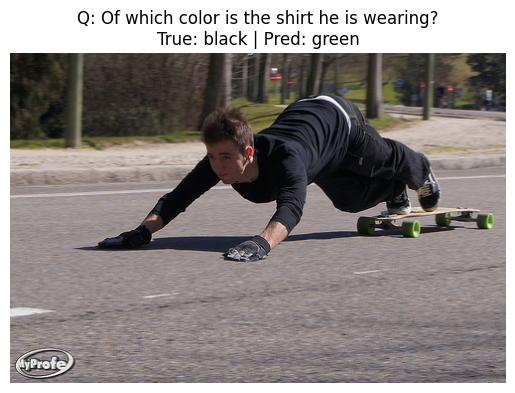

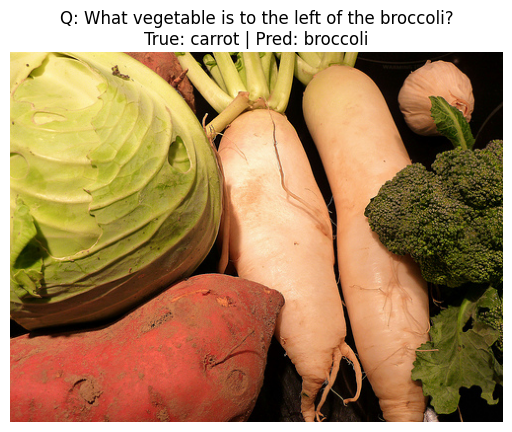

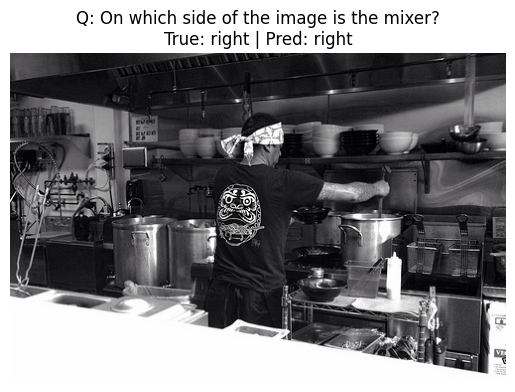

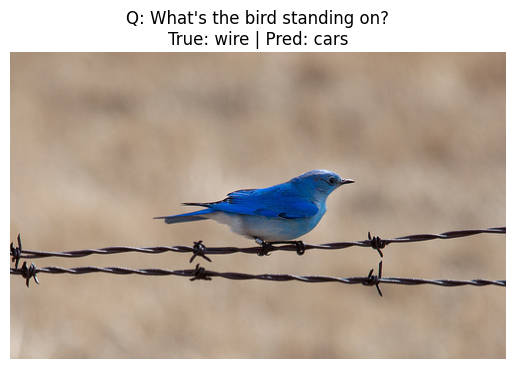

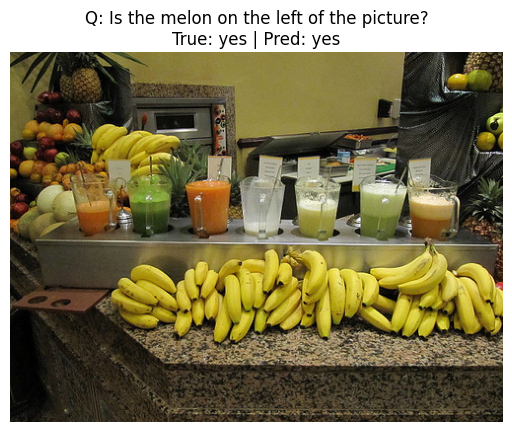

In [10]:
import random
from PIL import Image
import matplotlib.pyplot as plt

# Load best model
model.load_state_dict(torch.load("best_fusion_model.pt"))
model.eval()

# -------------------------------
# Evaluate overall metrics
# -------------------------------
val_loss, preds, trues = 0.0, [], []
with torch.no_grad():
    for batch in tqdm(val_loader, desc="Final Eval", leave=False):
        if batch is None:
            continue
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        pixel_values = batch["pixel_values"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(input_ids, attention_mask, pixel_values)
        loss = criterion(outputs, labels)
        val_loss += loss.item()

        preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
        trues.extend(labels.cpu().numpy())

final_acc = accuracy_score(trues, preds)
final_f1 = f1_score(trues, preds, average="weighted")

print(f"✅ Final Val Loss: {val_loss/len(val_loader):.4f}")
print(f"✅ Final Accuracy: {final_acc:.4f}")
print(f"✅ Final Weighted F1: {final_f1:.4f}")

# -------------------------------
# Show sample predictions
# -------------------------------
SAMPLES = 5
indices = random.sample(range(len(df_val)), SAMPLES)

for i in indices:
    row = df_val.iloc[i]
    image_path = os.path.join(IMAGE_DIR, f"{row['imageId']}.jpg")
    if not os.path.exists(image_path):
        continue

    img = Image.open(image_path).convert("RGB")
    inputs = preprocess_batch(row)
    if inputs is None:
        continue

    input_ids = inputs["input_ids"].unsqueeze(0).to(device)
    attention_mask = inputs["attention_mask"].unsqueeze(0).to(device)
    pixel_values = inputs["pixel_values"].unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(input_ids, attention_mask, pixel_values)
        pred_label = torch.argmax(outputs, dim=1).item()

    plt.imshow(img)
    plt.axis("off")
    plt.title(
        f"Q: {row['question']}\nTrue: {row['answer']} | Pred: {label2answer[pred_label]}"
    )
    plt.show()



In [12]:
import torch
import torch.nn as nn
from transformers import BertModel, ViTModel

class LateFusionModel(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        # Independent backbones
        self.text_model = BertModel.from_pretrained("bert-base-uncased")
        self.image_model = ViTModel.from_pretrained("google/vit-base-patch16-224")

        # Separate classification heads
        self.text_head = nn.Sequential(
            nn.Linear(self.text_model.config.hidden_size, 512),
            nn.ReLU(),
            nn.Dropout(0.3)
        )
        self.image_head = nn.Sequential(
            nn.Linear(self.image_model.config.hidden_size, 512),
            nn.ReLU(),
            nn.Dropout(0.3)
        )

        # Fusion + final classifier
        self.fusion = nn.Sequential(
            nn.Linear(512 * 2, 512),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(512, num_classes)
        )

    def forward(self, input_ids, attention_mask, pixel_values):
        # Encode text and image separately
        text_feats = self.text_model(input_ids=input_ids, attention_mask=attention_mask).pooler_output
        img_feats = self.image_model(pixel_values=pixel_values).pooler_output

        # Get intermediate representations
        text_emb = self.text_head(text_feats)
        img_emb = self.image_head(img_feats)

        # Concatenate and classify
        fused = torch.cat([text_emb, img_emb], dim=1)
        logits = self.fusion(fused)
        return logits

import torch.optim as optim  # <-- Add this import here

# -------------------------------
# Initialize model
# -------------------------------
num_classes = len(answer2label)
model_late = LateFusionModel(num_classes).to(device)
optimizer_late = optim.AdamW(model_late.parameters(), lr=2e-5)
criterion_late = nn.CrossEntropyLoss()

print(f"✅ Late Fusion model initialized on {device} with {num_classes} output classes")


Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Late Fusion model initialized on cuda with 584 output classes


In [13]:
from tqdm.auto import tqdm
from sklearn.metrics import accuracy_score, f1_score

EPOCHS = 5
best_val_acc = 0.0

for epoch in range(1, EPOCHS + 1):
    # ---------------------------
    # Training Phase
    # ---------------------------
    model_late.train()
    total_loss = 0.0
    loop = tqdm(train_loader, desc=f"📘 Epoch {epoch}/{EPOCHS}", leave=False)

    for batch in loop:
        optimizer_late.zero_grad()

        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        pixel_values = batch["pixel_values"].to(device)
        labels = batch["labels"].to(device)

        outputs = model_late(input_ids, attention_mask, pixel_values)
        loss = criterion_late(outputs, labels)
        loss.backward()
        optimizer_late.step()

        total_loss += loss.item()
        loop.set_postfix(loss=loss.item())

    avg_train_loss = total_loss / len(train_loader)

    # ---------------------------
    # Validation Phase
    # ---------------------------
    model_late.eval()
    val_loss, preds, trues = 0.0, [], []

    with torch.no_grad():
        for batch in tqdm(val_loader, desc="Validating", leave=False):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            pixel_values = batch["pixel_values"].to(device)
            labels = batch["labels"].to(device)

            outputs = model_late(input_ids, attention_mask, pixel_values)
            loss = criterion_late(outputs, labels)
            val_loss += loss.item()

            preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
            trues.extend(labels.cpu().numpy())

    avg_val_loss = val_loss / len(val_loader)
    val_acc = accuracy_score(trues, preds)
    val_f1 = f1_score(trues, preds, average="weighted")

    print(f"\n📘 Epoch {epoch}/{EPOCHS}")
    print(f"Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.4f} | Val F1: {val_f1:.4f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model_late.state_dict(), "best_late_fusion.pth")
        print("✅ Model saved (best so far)")


📘 Epoch 1/5:   0%|          | 0/625 [00:00<?, ?it/s]

Validating:   0%|          | 0/125 [00:00<?, ?it/s]


📘 Epoch 1/5
Train Loss: 4.3320 | Val Loss: 3.2677 | Val Acc: 0.2680 | Val F1: 0.1724
✅ Model saved (best so far)


📘 Epoch 2/5:   0%|          | 0/625 [00:00<?, ?it/s]

Validating:   0%|          | 0/125 [00:00<?, ?it/s]


📘 Epoch 2/5
Train Loss: 3.4100 | Val Loss: 3.0418 | Val Acc: 0.2702 | Val F1: 0.2360
✅ Model saved (best so far)


📘 Epoch 3/5:   0%|          | 0/625 [00:00<?, ?it/s]

Validating:   0%|          | 0/125 [00:00<?, ?it/s]


📘 Epoch 3/5
Train Loss: 3.1824 | Val Loss: 2.9372 | Val Acc: 0.3143 | Val F1: 0.2146
✅ Model saved (best so far)


📘 Epoch 4/5:   0%|          | 0/625 [00:00<?, ?it/s]

Validating:   0%|          | 0/125 [00:00<?, ?it/s]


📘 Epoch 4/5
Train Loss: 2.9920 | Val Loss: 2.8426 | Val Acc: 0.3272 | Val F1: 0.2597
✅ Model saved (best so far)


📘 Epoch 5/5:   0%|          | 0/625 [00:00<?, ?it/s]

Validating:   0%|          | 0/125 [00:00<?, ?it/s]


📘 Epoch 5/5
Train Loss: 2.7595 | Val Loss: 2.8809 | Val Acc: 0.3143 | Val F1: 0.2557


In [15]:
batch = next(iter(train_loader))
print(batch.keys())


dict_keys(['input_ids', 'attention_mask', 'pixel_values', 'labels'])


In [20]:
import torch
import torch.nn as nn
from transformers import ViTModel, BertModel

# --- Simple Cross-Attention Block ---
class CrossAttentionBlock(nn.Module):
    def __init__(self, embed_dim, num_heads=4):
        super(CrossAttentionBlock, self).__init__()
        self.cross_attn = nn.MultiheadAttention(embed_dim, num_heads, batch_first=True)
        self.ln = nn.LayerNorm(embed_dim)
        self.ff = nn.Sequential(
            nn.Linear(embed_dim, embed_dim * 2),
            nn.GELU(),
            nn.Linear(embed_dim * 2, embed_dim)
        )
        self.dropout = nn.Dropout(0.1)

    def forward(self, query, context):
        # query attends to context (e.g., text attends to image or vice versa)
        attn_output, _ = self.cross_attn(query, context, context)
        x = self.ln(query + self.dropout(attn_output))
        x = self.ln(x + self.dropout(self.ff(x)))
        return x

# --- Hybrid Fusion Model ---
class HybridFusionModel(nn.Module):
    def __init__(self, num_classes):
        super(HybridFusionModel, self).__init__()
        self.vit = ViTModel.from_pretrained("google/vit-base-patch16-224")
        self.bert = BertModel.from_pretrained("bert-base-uncased")

        # Freeze base layers (optional)
        for param in list(self.vit.parameters())[:100]:
            param.requires_grad = False
        for param in list(self.bert.parameters())[:100]:
            param.requires_grad = False

        embed_dim = 768  # both ViT and BERT have 768 hidden size

        self.cross_attn_text_to_img = CrossAttentionBlock(embed_dim)
        self.cross_attn_img_to_text = CrossAttentionBlock(embed_dim)

        self.fc_fuse = nn.Sequential(
            nn.Linear(embed_dim * 2, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )

    def forward(self, images, input_ids, attention_mask):
        # ViT outputs
        vit_out = self.vit(images).last_hidden_state  # [B, 197, 768]
        vit_cls = vit_out[:, 0, :].unsqueeze(1)       # [B, 1, 768]

        # BERT outputs
        bert_out = self.bert(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state
        bert_cls = bert_out[:, 0, :].unsqueeze(1)     # [B, 1, 768]

        # Cross Attention
        text_to_img = self.cross_attn_text_to_img(bert_cls, vit_out)  # text attends to image
        img_to_text = self.cross_attn_img_to_text(vit_cls, bert_out)  # image attends to text

        # Fuse both modalities
        fused = torch.cat([text_to_img.squeeze(1), img_to_text.squeeze(1)], dim=1)
        output = self.fc_fuse(fused)
        return output

# --- Initialize Model ---
num_classes = len(answer2label)
model_hybrid = HybridFusionModel(num_classes).to(device)

optimizer_hybrid = torch.optim.AdamW(model_hybrid.parameters(), lr=3e-5)
criterion_hybrid = nn.CrossEntropyLoss()

print(f"✅ Hybrid Fusion model initialized on {device} with {num_classes} output classes")


Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Hybrid Fusion model initialized on cuda with 584 output classes


In [21]:
import numpy as np
from sklearn.metrics import f1_score

best_f1 = 0.0

print("📘 Starting Hybrid Fusion Training...")

for epoch in range(1, 6):  # you can increase to 10 if GPU allows
    model_hybrid.train()
    train_loss = 0.0

    for batch in train_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        images = batch["pixel_values"].to(device)
        labels = batch["labels"].to(device)

        # safety squeeze
        if input_ids.dim() == 3:
            input_ids = input_ids.squeeze(1)
        if attention_mask.dim() == 3:
            attention_mask = attention_mask.squeeze(1)

        optimizer_hybrid.zero_grad()
        outputs = model_hybrid(images, input_ids, attention_mask)
        loss = criterion_hybrid(outputs, labels)
        loss.backward()
        optimizer_hybrid.step()

        train_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader)

    # ----- Validation -----
    model_hybrid.eval()
    val_loss, preds, truths = 0.0, [], []

    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            images = batch["pixel_values"].to(device)
            labels = batch["labels"].to(device)

            if input_ids.dim() == 3:
                input_ids = input_ids.squeeze(1)
            if attention_mask.dim() == 3:
                attention_mask = attention_mask.squeeze(1)

            outputs = model_hybrid(images, input_ids, attention_mask)
            loss = criterion_hybrid(outputs, labels)
            val_loss += loss.item()

            preds.extend(outputs.argmax(dim=1).cpu().numpy())
            truths.extend(labels.cpu().numpy())

    val_loss /= len(val_loader)
    preds, truths = np.array(preds), np.array(truths)
    val_acc = (preds == truths).mean()
    val_f1 = f1_score(truths, preds, average="macro")

    print(f"\n📘 Epoch {epoch}/5")
    print(f"Train Loss: {avg_train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f} | Val F1: {val_f1:.4f}")

    # ----- Model Saving -----
    if val_f1 > best_f1:
        best_f1 = val_f1
        torch.save(model_hybrid.state_dict(), "best_hybrid_fusion.pt")
        print("✅ Model saved (best so far)")

print("\n🎯 Hybrid Fusion Training Complete.")


📘 Starting Hybrid Fusion Training...

📘 Epoch 1/5
Train Loss: 3.6445 | Val Loss: 2.7456 | Val Acc: 0.3251 | Val F1: 0.0426
✅ Model saved (best so far)

📘 Epoch 2/5
Train Loss: 2.5627 | Val Loss: 2.4300 | Val Acc: 0.3724 | Val F1: 0.0838
✅ Model saved (best so far)

📘 Epoch 3/5
Train Loss: 1.9121 | Val Loss: 2.3038 | Val Acc: 0.3735 | Val F1: 0.0953
✅ Model saved (best so far)

📘 Epoch 4/5
Train Loss: 1.3164 | Val Loss: 2.2434 | Val Acc: 0.3950 | Val F1: 0.1214
✅ Model saved (best so far)

📘 Epoch 5/5
Train Loss: 0.8506 | Val Loss: 2.2664 | Val Acc: 0.3961 | Val F1: 0.1403
✅ Model saved (best so far)

🎯 Hybrid Fusion Training Complete.


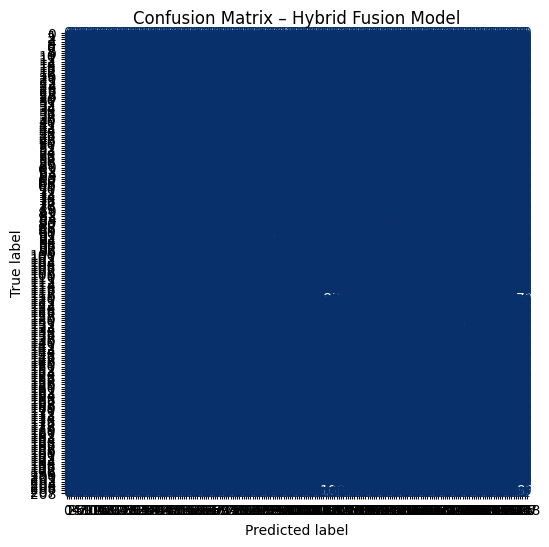

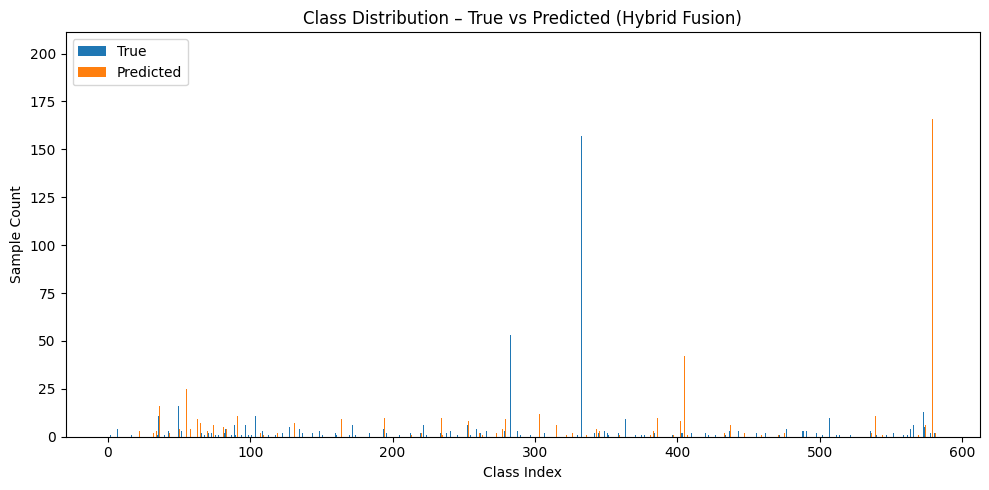

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# ✅ Get predictions on validation data
model_hybrid.eval()
preds, truths = [], []

with torch.no_grad():
    for batch in val_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        images = batch["pixel_values"].to(device)
        labels = batch["labels"].to(device)

        # shape safety
        if input_ids.dim() == 3:
            input_ids = input_ids.squeeze(1)
        if attention_mask.dim() == 3:
            attention_mask = attention_mask.squeeze(1)

        outputs = model_hybrid(images, input_ids, attention_mask)
        preds.extend(outputs.argmax(dim=1).cpu().numpy())
        truths.extend(labels.cpu().numpy())

# Convert to numpy arrays
preds, truths = np.array(preds), np.array(truths)

# ----- Confusion Matrix -----
cm = confusion_matrix(truths, preds)
fig, ax = plt.subplots(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(ax=ax, cmap="Blues", colorbar=False)
plt.title("Confusion Matrix – Hybrid Fusion Model")
plt.show()

# ----- Class Distribution Comparison -----
true_counts = np.bincount(truths, minlength=len(answer2label))
pred_counts = np.bincount(preds, minlength=len(answer2label))

fig, ax = plt.subplots(figsize=(10, 5))
x = np.arange(len(answer2label))
ax.bar(x - 0.2, true_counts, width=0.4, label="True")
ax.bar(x + 0.2, pred_counts, width=0.4, label="Predicted")
ax.set_title("Class Distribution – True vs Predicted (Hybrid Fusion)")
ax.set_xlabel("Class Index")
ax.set_ylabel("Sample Count")
ax.legend()
plt.tight_layout()
plt.show()
